In [1]:
from glob import glob
from astroquery.mast import Mast, Observations
import os
import shutil
import numpy as np
import json
import requests
import asdf
from astropy import log
from astropy import wcs
from astropy.io import ascii, fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch
from astropy.wcs.utils import skycoord_to_pixel
from astropy.nddata import extract_array

import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table

import astropy.units as u

from jwst import assign_wcs#.util.update_fits_wcsinfo
from jwst.datamodels import ImageModel

import sys
sys.path.append('../')
import destreak
import image1overf
import smooth1overf

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['image.origin'] = 'lower'

os.environ["CRDS_PATH"] = "/orange/adamginsburg/jwst/w51/crds/"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

2025-05-21 11:43:29,838 - stpipe - WARNING - /home/t.yoo/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



In [2]:
ls /orange/adamginsburg/jwst/cloudc/F4*/pipeline/*merged_i2d.fits

/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/F410M/pipeline/jw02221-o002_t001_nircam_clear-f410m-merged_i2d.fits
/orange/adamginsburg/jwst/cloudc/F466N/pipeline/jw02221-o002_t001_nircam_clear-f466n-merged_i2d.fits


In [3]:
basepath = '/orange/adamginsburg/jwst/w51/'

In [4]:
#filt = 'F405N'
#file = 'jw02221002001_02201_00001_nrcblong'
#filt = 'F212N'
#file = 'jw02221002001_04201_00002_nrcb4'
#filt = 'F187N'
#file = 'jw02221002001_02201_00002_nrcb4'
#filt = 'F182M'
#file = 'jw02221002002_06201_00003_nrcb4'
#filt = 'F410M'
#file = 'jw02221002001_06201_00003_nrcblong'
#filt = 'F466N'
#file = 'jw02221002001_04201_00002_nrcblong'
filt = 'F140M'
file = 'jw06151001001_03109_00008_nrcb4'
im = ImageModel(f'{basepath}/{filt}/pipeline/{file}_destreak.fits')
cal = ImageModel(f'{basepath}/{filt}/pipeline/{file}_cal.fits')

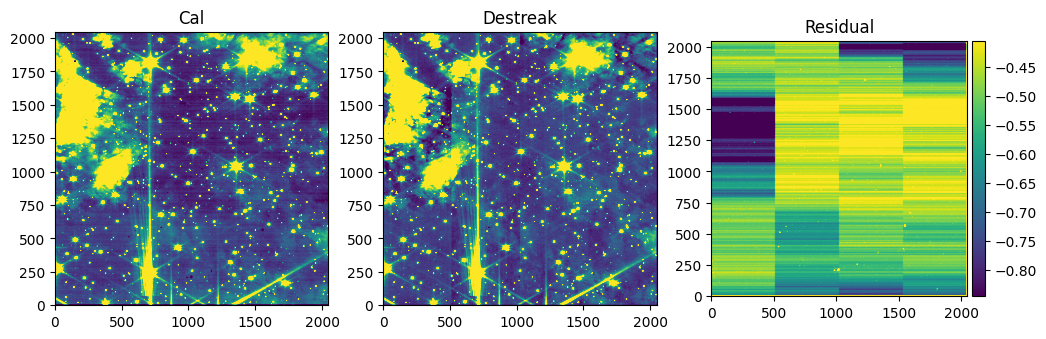

In [5]:
resid = im.data - cal.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(cal.data), vmin=np.nanpercentile(cal.data.flatten(), minn), vmax=np.nanpercentile(cal.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(im.data), vmin=np.nanpercentile(im.data.flatten(), minn), vmax=np.nanpercentile(im.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(resid.data), vmin=np.nanpercentile(resid.flatten(), minn), vmax=np.nanpercentile(resid.flatten(), maxx))

axs[0].set_title('Cal')
axs[1].set_title('Destreak')
axs[2].set_title('Residual')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

In [6]:
out_destreak = destreak.destreak(f'{basepath}/{filt}/pipeline/{file}_cal.fits', percentile=10, median_filter_size=256, overwrite=False, write=False,
             #background_folder='/orange/adamginsburg/jwst/brick/images/',
             #background_mapping=background_mapping,
             use_background_map=False
             )

2025-05-21 11:43:33,773 - stpipe - WARNING - /home/t.yoo/anaconda3/envs/py311/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,



Destreaking /orange/adamginsburg/jwst/w51//F140M/pipeline/jw06151001001_03109_00008_nrcb4_cal.fits


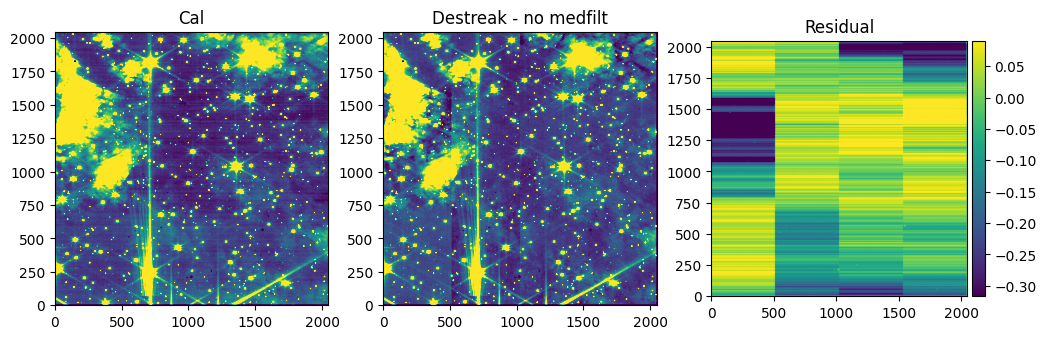

In [7]:
des = out_destreak['SCI']
resid = des.data - cal.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(cal.data), vmin=np.nanpercentile(cal.data.flatten(), minn), vmax=np.nanpercentile(cal.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(des.data), vmin=np.nanpercentile(des.data.flatten(), minn), vmax=np.nanpercentile(des.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(resid.data), vmin=np.nanpercentile(resid.flatten(), minn), vmax=np.nanpercentile(resid.flatten(), maxx))

axs[0].set_title('Cal')
axs[1].set_title('Destreak - no medfilt')
axs[2].set_title('Residual')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

In [8]:
out_im1overf = image1overf.sub1fimaging(fits.open(f'{basepath}/{filt}/pipeline/{file}_cal.fits'), 3.0, 2.0, False, True)

2025-05-21 11:43:38,284 - stpipe - WARNING - /home/t.yoo/anaconda3/envs/py311/lib/python3.11/site-packages/astropy/convolution/convolve.py:427: AstropyUserWarning: nan_treatment='interpolate', however, NaN values detected post convolution. A contiguous region of NaN values, larger than the kernel size, are present in the input array. Increase the kernel size to avoid this.
  warnings.warn(



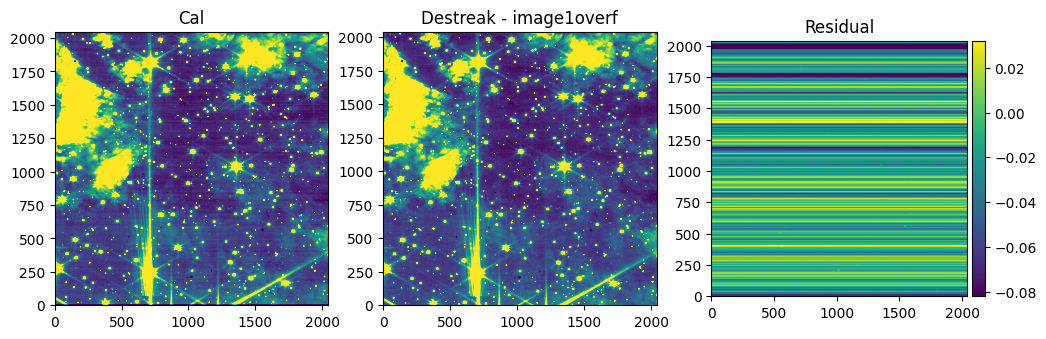

In [9]:
resid = out_im1overf.data - cal.data[4:2044,4:2044]

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(cal.data), vmin=np.nanpercentile(cal.data.flatten(), minn), vmax=np.nanpercentile(cal.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf.data), vmin=np.nanpercentile(out_im1overf.data.flatten(), minn), vmax=np.nanpercentile(out_im1overf.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(resid.data), vmin=np.nanpercentile(resid.flatten(), minn), vmax=np.nanpercentile(resid.flatten(), maxx))

axs[0].set_title('Cal')
axs[1].set_title('Destreak - image1overf')
axs[2].set_title('Residual')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

In [10]:
out_im1overf_col = image1overf.sub1fimaging(fits.open(f'{basepath}/{filt}/pipeline/{file}_cal.fits'), 3.0, 2.0, True, True)

2025-05-21 11:43:42,528 - stpipe - WARNING - /home/t.yoo/anaconda3/envs/py311/lib/python3.11/site-packages/astropy/convolution/convolve.py:427: AstropyUserWarning: nan_treatment='interpolate', however, NaN values detected post convolution. A contiguous region of NaN values, larger than the kernel size, are present in the input array. Increase the kernel size to avoid this.
  warnings.warn(



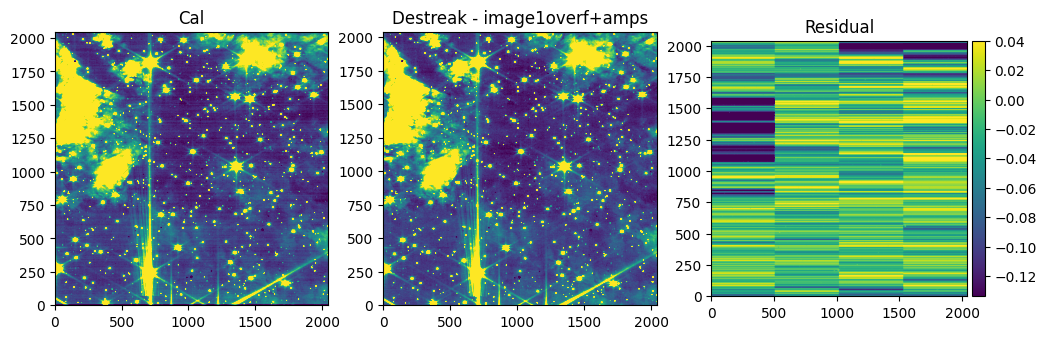

In [11]:
resid = out_im1overf_col.data - cal.data[4:2044,4:2044]

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(cal.data), vmin=np.nanpercentile(cal.data.flatten(), minn), vmax=np.nanpercentile(cal.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf_col), vmin=np.nanpercentile(out_im1overf_col.flatten(), minn), vmax=np.nanpercentile(out_im1overf_col.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(resid.data), vmin=np.nanpercentile(resid.flatten(), minn), vmax=np.nanpercentile(resid.flatten(), maxx))

axs[0].set_title('Cal')
axs[1].set_title('Destreak - image1overf+amps')
axs[2].set_title('Residual')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

In [12]:
smo = smooth1overf.smooth_1overf_correction(cal.data)

2025-05-21 11:43:45,202 - stpipe - WARNING - /home/t.yoo/anaconda3/envs/py311/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:376: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(

2025-05-21 11:43:45,485 - stpipe - WARNING - /home/t.yoo/anaconda3/envs/py311/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:1041: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)

2025-05-21 11:43:45,486 - stpipe - WARNING - /home/t.yoo/anaconda3/envs/py311/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1217: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,

2025-05-21 11:43:45,683 - stpipe - WARNING - /home/t.yoo/anaconda3/envs/py311/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,

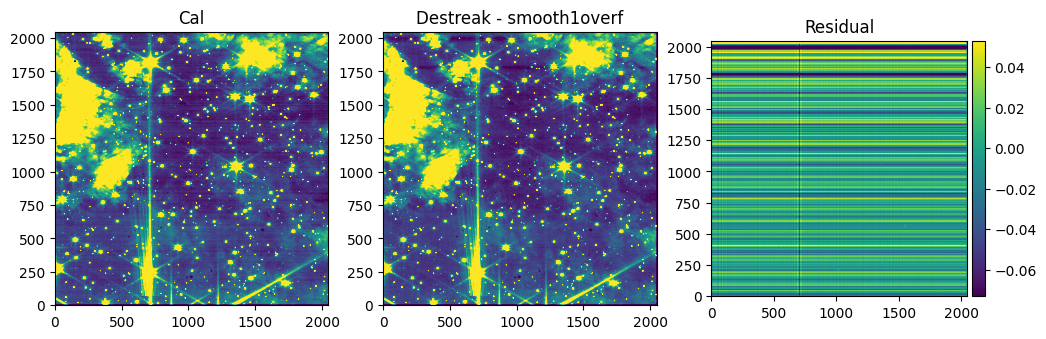

In [13]:
resid = smo - cal.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(cal.data), vmin=np.nanpercentile(cal.data.flatten(), minn), vmax=np.nanpercentile(cal.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(smo), vmin=np.nanpercentile(smo.flatten(), minn), vmax=np.nanpercentile(smo.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(resid.data), vmin=np.nanpercentile(resid.flatten(), minn), vmax=np.nanpercentile(resid.flatten(), maxx))

axs[0].set_title('Cal')
axs[1].set_title('Destreak - smooth1overf')
axs[2].set_title('Residual')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

# Comparing Different Methods

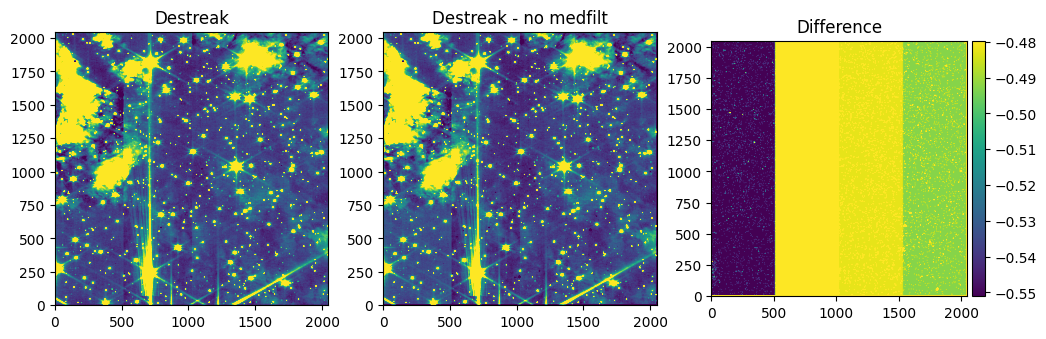

In [14]:
diff = im.data - des.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(im.data), vmin=np.nanpercentile(im.data.flatten(), minn), vmax=np.nanpercentile(im.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(des.data), vmin=np.nanpercentile(des.data.flatten(), minn), vmax=np.nanpercentile(des.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak')
axs[1].set_title('Destreak - no medfilt')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

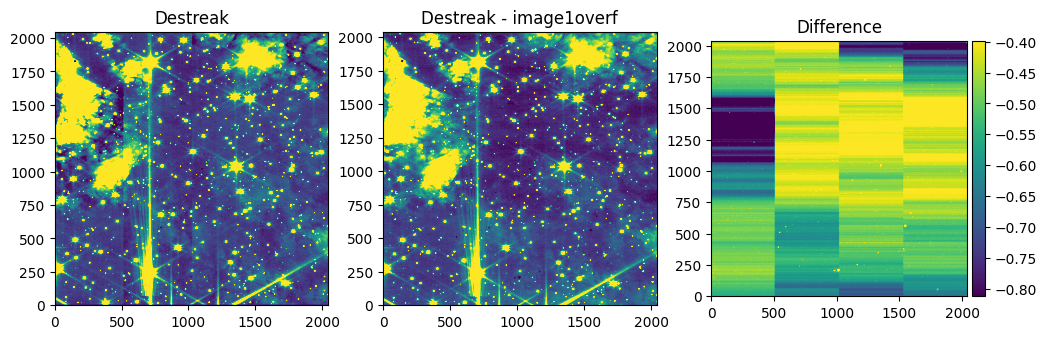

In [15]:
diff = im.data[4:2044,4:2044] - out_im1overf.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(im.data), vmin=np.nanpercentile(im.data.flatten(), minn), vmax=np.nanpercentile(im.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf.data), vmin=np.nanpercentile(out_im1overf.data.flatten(), minn), vmax=np.nanpercentile(out_im1overf.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak')
axs[1].set_title('Destreak - image1overf')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

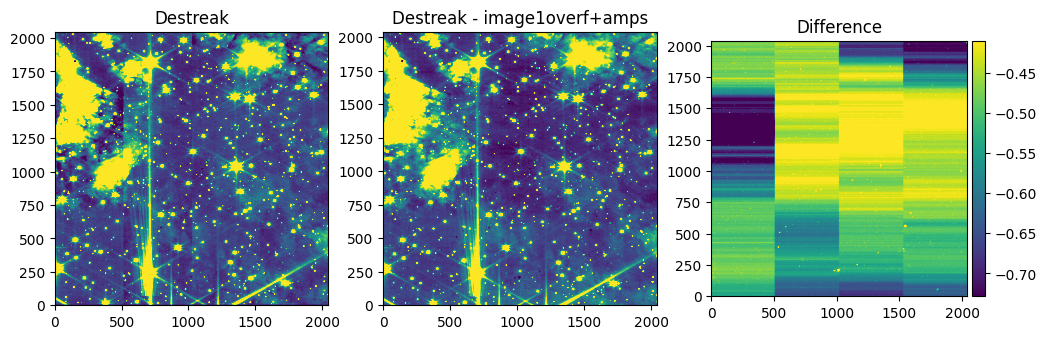

In [16]:
diff = im.data[4:2044,4:2044] - out_im1overf_col.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(im.data), vmin=np.nanpercentile(im.data.flatten(), minn), vmax=np.nanpercentile(im.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf_col), vmin=np.nanpercentile(out_im1overf_col.flatten(), minn), vmax=np.nanpercentile(out_im1overf_col.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak')
axs[1].set_title('Destreak - image1overf+amps')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

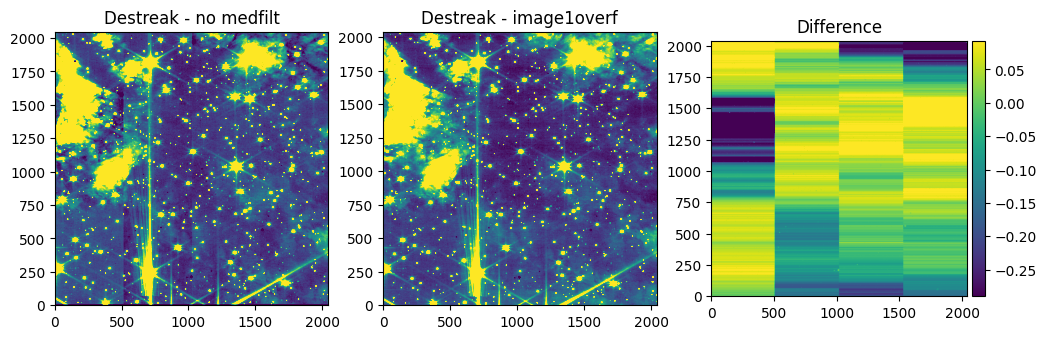

In [17]:
diff = des.data[4:2044,4:2044] - out_im1overf.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(des.data), vmin=np.nanpercentile(des.data.flatten(), minn), vmax=np.nanpercentile(des.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf.data), vmin=np.nanpercentile(out_im1overf.data.flatten(), minn), vmax=np.nanpercentile(out_im1overf.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - no medfilt')
axs[1].set_title('Destreak - image1overf')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

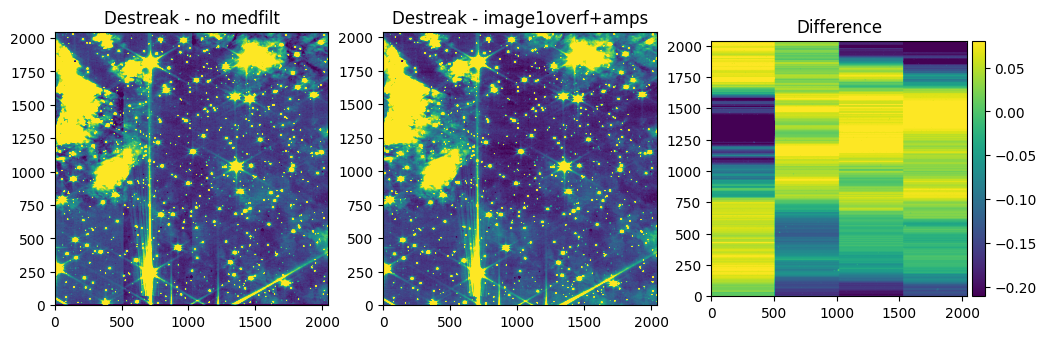

In [18]:
diff = des.data[4:2044,4:2044] - out_im1overf_col

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(des.data), vmin=np.nanpercentile(des.data.flatten(), minn), vmax=np.nanpercentile(des.data.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf_col), vmin=np.nanpercentile(out_im1overf_col.flatten(), minn), vmax=np.nanpercentile(out_im1overf_col.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - no medfilt')
axs[1].set_title('Destreak - image1overf+amps')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

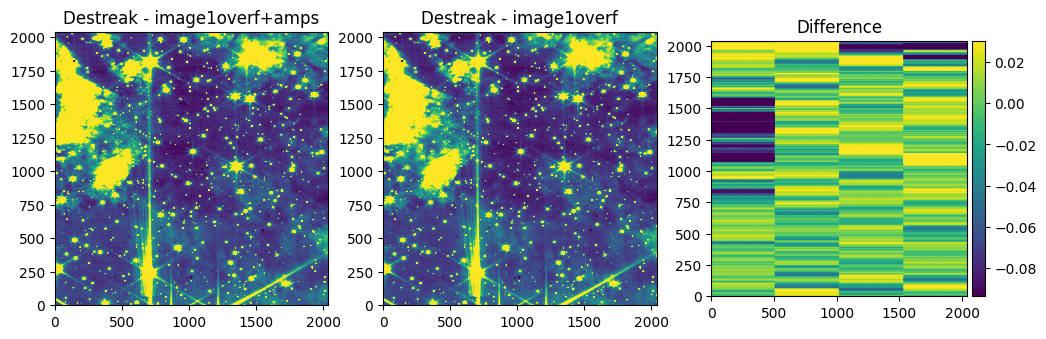

In [19]:
diff = out_im1overf_col - out_im1overf.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(out_im1overf_col), vmin=np.nanpercentile(out_im1overf_col.flatten(), minn), vmax=np.nanpercentile(out_im1overf_col.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf.data), vmin=np.nanpercentile(out_im1overf.data.flatten(), minn), vmax=np.nanpercentile(out_im1overf.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - image1overf+amps')
axs[1].set_title('Destreak - image1overf')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

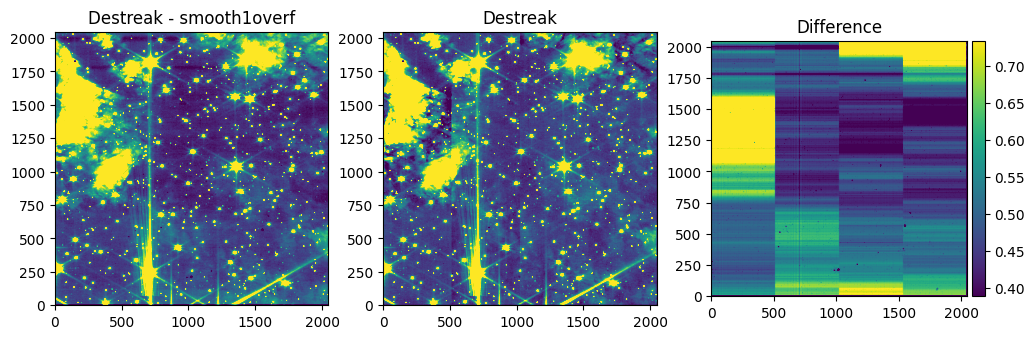

In [20]:
diff = smo - im.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(smo), vmin=np.nanpercentile(smo.flatten(), minn), vmax=np.nanpercentile(smo.flatten(), maxx))
axs[1].imshow(np.nan_to_num(im.data), vmin=np.nanpercentile(im.data.flatten(), minn), vmax=np.nanpercentile(im.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - smooth1overf')
axs[1].set_title('Destreak')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

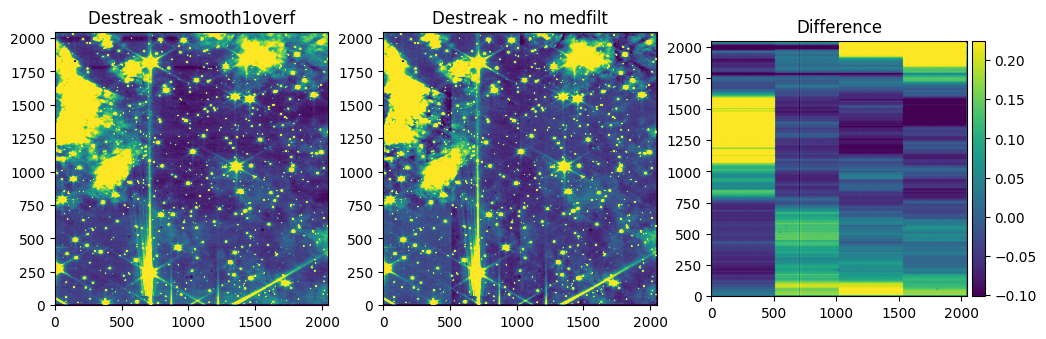

In [21]:
diff = smo - des.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(smo), vmin=np.nanpercentile(smo.flatten(), minn), vmax=np.nanpercentile(smo.flatten(), maxx))
axs[1].imshow(np.nan_to_num(des.data), vmin=np.nanpercentile(des.data.flatten(), minn), vmax=np.nanpercentile(des.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - smooth1overf')
axs[1].set_title('Destreak - no medfilt')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

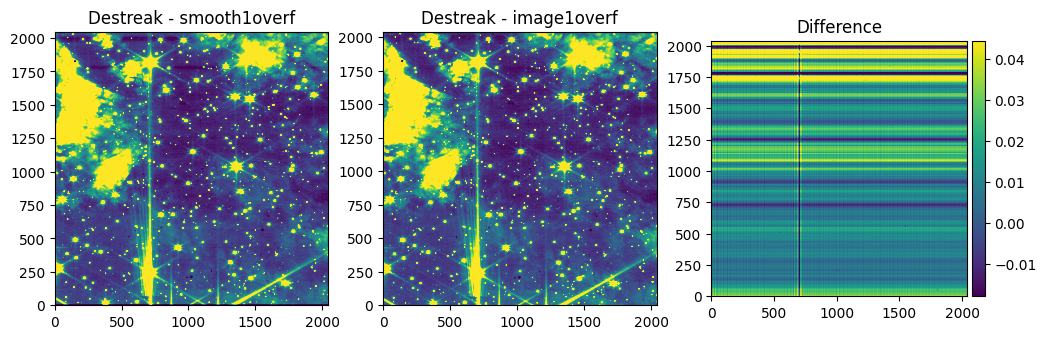

In [22]:
diff = smo[4:2044,4:2044] - out_im1overf.data

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(smo), vmin=np.nanpercentile(smo.flatten(), minn), vmax=np.nanpercentile(smo.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf.data), vmin=np.nanpercentile(out_im1overf.data.flatten(), minn), vmax=np.nanpercentile(out_im1overf.data.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - smooth1overf')
axs[1].set_title('Destreak - image1overf')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

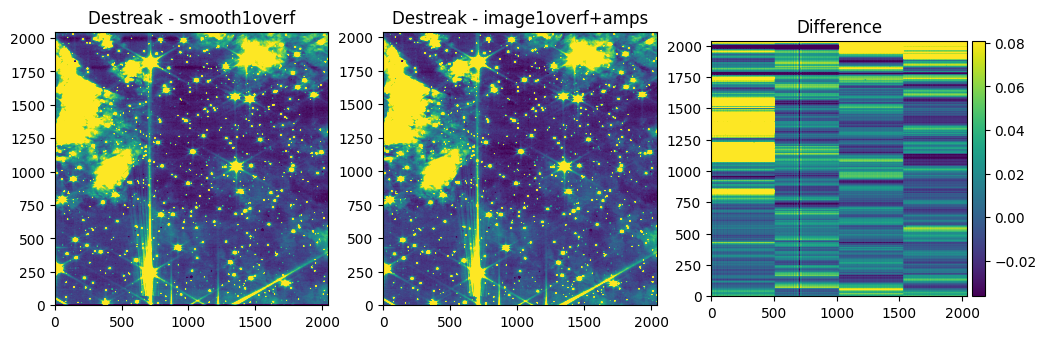

In [23]:
diff = smo[4:2044,4:2044] - out_im1overf_col

fig, axs = plt.subplots(1,3, figsize=(12, 12))
minn = 5
maxx = 90

axs[0].imshow(np.nan_to_num(smo), vmin=np.nanpercentile(smo.flatten(), minn), vmax=np.nanpercentile(smo.flatten(), maxx))
axs[1].imshow(np.nan_to_num(out_im1overf_col), vmin=np.nanpercentile(out_im1overf_col.flatten(), minn), vmax=np.nanpercentile(out_im1overf_col.flatten(), maxx))
c = axs[2].imshow(np.nan_to_num(diff.data), vmin=np.nanpercentile(diff.flatten(), minn), vmax=np.nanpercentile(diff.flatten(), maxx))

axs[0].set_title('Destreak - smooth1overf')
axs[1].set_title('Destreak - image1overf+amps')
axs[2].set_title('Difference')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(c, cax=cax, orientation='vertical')
plt.show()

In [24]:
print('save')

save
